In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
import math
%matplotlib inline

In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

In [3]:
#basic transformation
def transformData(dataSet):
    latceil = math.ceil(np.mean(dataSet.latitude) + 2*np.std(dataSet.latitude))
    latfloor = math.floor(np.mean(dataSet.latitude) - 2*np.std(dataSet.latitude))
    longceil = math.ceil(np.mean(train.longitude) + 2*np.std(train.longitude))
    longfloor = math.floor(np.mean(train.longitude) - 2*np.std(train.longitude))
    dataSet['num_features'] = dataSet['features'].str.len()
    dataSet['num_words_desc'] = dataSet['description'].str.split().str.len()
    dataSet["num_photos"] = dataSet["photos"].apply(len)
    dataSet["created"] = pd.to_datetime(dataSet["created"])
    dataSet["created_year"] = dataSet["created"].dt.year
    dataSet["created_month"] = dataSet["created"].dt.month
    dataSet["created_day"] = dataSet["created"].dt.day
    dataSet["created_hour"] = dataSet["created"].dt.hour
    missingCoords = dataSet[(dataSet.longitude > longceil) | (dataSet.longitude < longfloor) | (dataSet.latitude > latceil) | (dataSet.latitude < latfloor)]
    missingGeoms = (missingCoords.street_address + ' New York').apply(geocoder.google)
    dataSet.loc[(dataSet.longitude > longceil) | (dataSet.longitude < longfloor) | (dataSet.latitude > latceil) | (dataSet.latitude < latfloor), \
                'latitude'] = missingGeoms.apply(lambda x: x.lat)
    dataSet.loc[(dataSet.longitude > longceil) | (dataSet.longitude < longfloor) | (dataSet.latitude > latceil) | (dataSet.latitude < latfloor), \
                'longitude'] = missingGeoms.apply(lambda x: x.lng)
    dataSet['bedbath_ratio'] = dataSet['bedrooms']/dataSet['bathrooms']
    dataSet.loc[dataSet.bathrooms == 0, 'bedbath_ratio'] = dataSet.loc[dataSet.bathrooms ==0, 'bedrooms']
    dataSet.loc[dataSet.bedbath_ratio == 0, 'bedbath_ratio'] = dataSet.loc[dataSet.bedbath_ratio ==0, 'bedbath_ratio'] + 1
#     bedbath_ratio set to number of bedrooms; when num bedroom == 0=> bedbath_ratio = 1
#     categorize bed and bath?
#     dataSet['bath_cat'] = [str(x) if x > 4 else str(x) for x in dataSet.bathrooms.apply(round).map(int)]
#     dataSet['bed_cat'] = [str(x) if x > 4 else str(x) for x in dataSet.bedrooms]


In [4]:
transformData(train)
transformData(test)

In [17]:
newcols = ['num_features','num_words_desc', "num_photos", "created_year", "created_month", "created_day", "created_hour", 'bedbath_ratio'] 
#'bed_cat', 'bath_cat', 'low_int', 'med_int', 'high_int'
train['low_int'] = (train['interest_level'] == 'low').astype(int)
train['med_int'] = (train['interest_level'] == 'medium').astype(int)
train['high_int'] = (train['interest_level'] == 'high').astype(int)
numericaltrain = train.select_dtypes(include=[np.number]).drop(['low_int', 'med_int', 'high_int'], axis=1)
numericalcolumns = list(numericaltrain)
def corrtable(x):
    a = []
    for i in numericalcolumns:
        b = kendalltau(train[x + '_int'],train[i])
        a.append([i, b[0], b[1]])
    a = pd.DataFrame(a)
    a.columns = ['columns', 'correlation', 'pvalue']
    a['abscorr'] = abs(a['correlation'])
    a = a[a['pvalue'] <0.05].sort_values(['abscorr'], ascending=[0])
    return a

In [9]:
print corrtable('high')
print corrtable('med')
print corrtable('low')

           columns  correlation         pvalue   abscorr
16        high_int     1.000000   0.000000e+00  1.000000
14         low_int    -0.438086   0.000000e+00  0.438086
15         med_int    -0.157623   0.000000e+00  0.157623
5            price    -0.157578   0.000000e+00  0.157578
12    created_hour     0.103642  2.377843e-261  0.103642
13   bedbath_ratio     0.064157  2.123533e-101  0.064157
0        bathrooms    -0.056114   5.124639e-78  0.056114
6     num_features    -0.025558   1.646384e-17  0.025558
11     created_day    -0.025097   6.124796e-17  0.025097
8       num_photos     0.019915   3.222530e-11  0.019915
7   num_words_desc     0.010761   3.359975e-04  0.010761
3       listing_id    -0.009767   1.135904e-03  0.009767
           columns  correlation         pvalue   abscorr
15         med_int     1.000000   0.000000e+00  1.000000
14         low_int    -0.818644   0.000000e+00  0.818644
16        high_int    -0.157623   0.000000e+00  0.157623
12    created_hour     0.118031

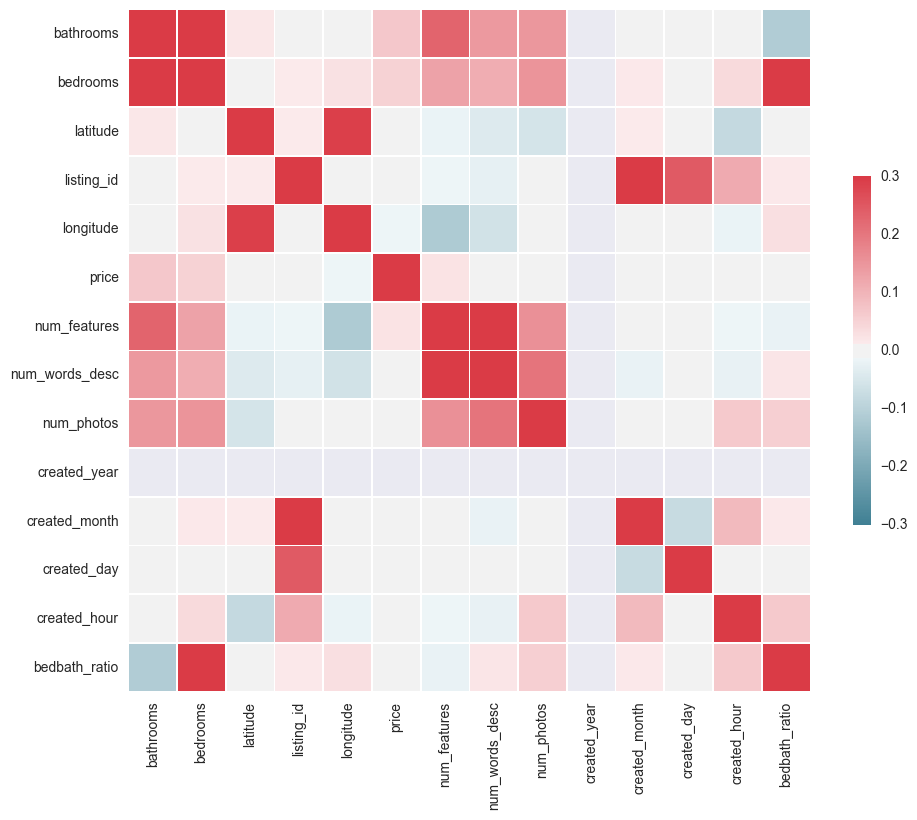

In [18]:
corrtrain = numericaltrain.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrtrain, cmap=cmap, vmax=.3, #mask = mask,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

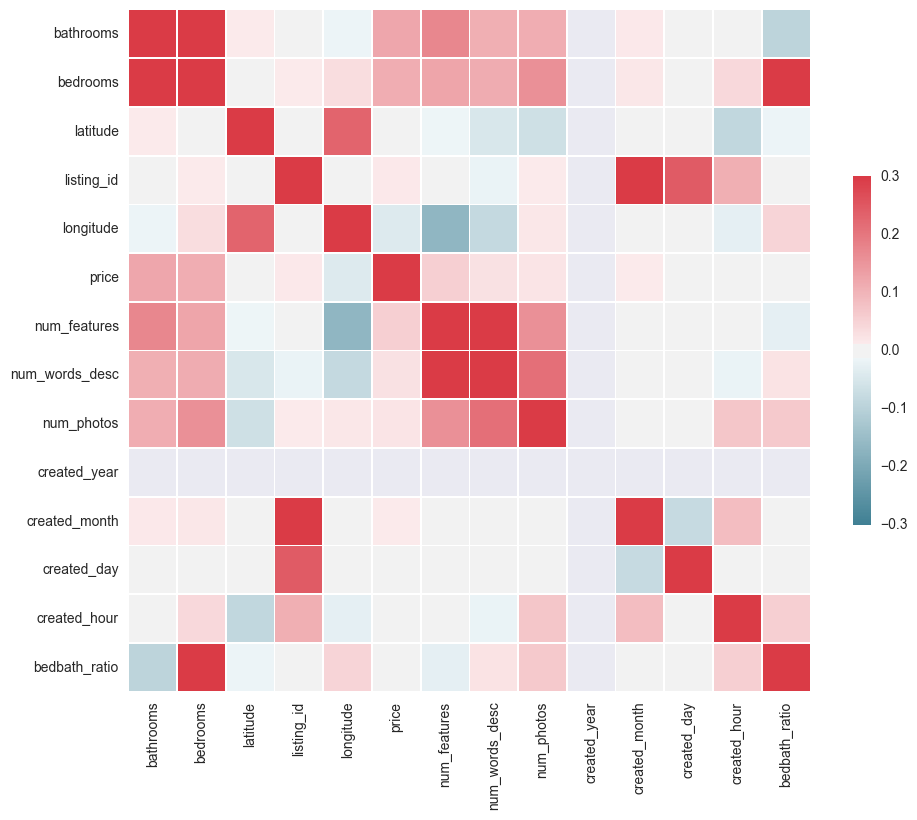

In [20]:
corrtest = test.select_dtypes(include=[np.number]).corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrtest, cmap=cmap, vmax=.3, #mask = mask,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [19]:
numericaltrain

,bathrooms,bedrooms,latitude,listing_id,longitude,price,num_features,num_words_desc,num_photos,created_year,created_month,created_day,created_hour,bedbath_ratio
10,1.5,3,40.7145,7211212,-73.9425,3000,0,93,5,2016,6,24,7,2.000000
10000,1.0,2,40.7947,7150865,-73.9667,5465,5,0,11,2016,6,12,12,2.000000
100004,1.0,1,40.7388,6887163,-74.0018,2850,4,92,8,2016,4,17,3,1.000000
100007,1.0,1,40.7539,6888711,-73.9677,3275,2,78,3,2016,4,18,2,1.000000
100013,1.0,4,40.8241,6934781,-73.9493,3350,1,67,3,2016,4,28,1,4.000000
100014,2.0,4,40.7429,6894514,-74.0028,7995,0,0,5,2016,4,19,4,2.000000
100016,1.0,2,40.8012,6930771,-73.9660,3600,8,85,10,2016,4,27,3,2.000000
100020,2.0,1,40.7427,6867392,-73.9957,5645,8,130,5,2016,4,13,6,0.500000
100026,1.0,1,40.8234,6898799,-73.9457,1725,4,2,5,2016,4,20,2,1.000000
100027,2.0,4,40.7278,6814332,-73.9808,5800,2,160,9,2016,4,2,2,2.000000


In [18]:
train[]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,num_words_desc,num_photos,created_year,created_month,created_day,created_hour,bedbath_ratio,low_int,med_int,high_int
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,93,5,2016,6,24,7,2.000000,0,1,0
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,0,11,2016,6,12,12,2.000000,1,0,0
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,92,8,2016,4,17,3,1.000000,0,0,1
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,78,3,2016,4,18,2,1.000000,1,0,0
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,67,3,2016,4,28,1,4.000000,1,0,0
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,...,0,5,2016,4,19,4,2.000000,0,1,0
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,...,85,10,2016,4,27,3,2.000000,1,0,0
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,...,130,5,2016,4,13,6,0.500000,1,0,0
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,...,2,5,2016,4,20,2,1.000000,0,1,0
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,...,160,9,2016,4,2,2,2.000000,1,0,0
